# Lubrication minus RP
Check if long-range Part in lubrication formulas by Jeffrey and Onishi (Jeffrey1984) is really the same as 2-particle Rotne-Prager
$$\lambda = \frac{q_2}{q_1} \qquad \text{and} \qquad s = \frac{2 r}{q_1 + q_2}$$
$q_i$ and $q_j$ the radii of particles

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

Offset at aop=0.5:  0.942809041582


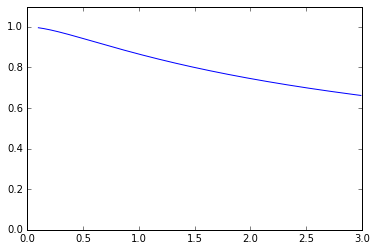

In [96]:
def cylsphereOffset(aop):
    return np.sqrt((1-(aop/(aop+1))**2))
avals=np.arange(0.1,3,0.01)
plt.plot(avals,cylsphereOffset(avals))
plt.ylim([0,1.1])
print("Offset at aop=0.5: ",cylsphereOffset(0.5))

In [2]:
f0 = lambda A: 1
f1 = lambda A: 3*A
f2 = lambda A: 9*A
f3 = lambda A: -4*A+27*A**2-4*A**3
f4 = lambda A: -24*A + 81*A**2 + 36*A**3
f5 = lambda A: 72*A**2 + 243*A**3 + 72*A**4
f6 = lambda A: 16*A + 108*A**2+ 281*A**3 + 648*A**4+ 144*A**5
f7 = 1
f8 = lambda A: 576*A**2 + 4848*A**3+ 5409*A**4 + 4524*A**5 + 3888*A**6+ 576*A**7
f9 = 1
fX=[f0,f2,f4,f6,f8]

fy0 = lambda A: 1
fy2 = lambda A: 9/4*A
fy4 = lambda A: 6*A+81/16*A**2+ 18*A**3
fy6 = lambda A: 4*A + 54*A**2+ 1241/64 *A**3 + 81*A**4 + 72*A**5
fy8 = lambda A: 279*A*2 + 4261/8*A**3 + 126369/256*A**4 - 117/8*A**5 + 648*A**6 + 288*A**7
fY = [fy0,fy2,fy4,fy6,fy8]


def X11LR(r,a,p,fs,drop=0):
    A = a/p
    s = r/(a+p) #leave out factor of 2, since I take diameters.
    res = 0
    i=0
    if drop != 0: fs = fs[:-drop]
    for fm in fs:
        m = 2*i
        res += fm(A)/(s**m *(1 + A)**m)
        i+=1
    return res

def longRangeR2p(rvec, p, a,drop=0):
    I = np.identity(3)
    r = LA.norm(rvec)
    rsq = r*r
    X11 = X11LR(r,a,p,fX,drop)
    Y11 = X11LR(r,a,p,fY,drop) 
    print("THIS CODE IS PROBABLY NOT CORRECT. USE getR() DEFINDE BELOW")
    return rvec.dot(rvec.T) / rsq * ( X11  - Y11 ) + I * X11

In [46]:
def RotnePragerTracerPoly(rvec, p, a):
    # due to the way that asq is defined here, this is the RP between the tracer of size p, and a polysphere of size a
    I = np.identity(3)
    _pradius = p/2.
    _polyrad = a/2.
    asq = (_polyrad * _polyrad + _pradius * _pradius)/2.
    r = LA.norm(rvec)
    rsq = r*r

    return _pradius * 3. / ( 4 * r ) * ( ( 1. + 2. * asq / (3. * rsq )) * I + ( 1. - 2.* asq / rsq ) * np.outer(rvec,rvec) / rsq )

def RotnePragerPolyPoly(rvec, p, a):
    I = np.identity(3)
    _pradius = p/2.
    _polyrad = a/2.
    asq = (_polyrad * _polyrad)
    r = LA.norm(rvec)
    rsq = r*r

    return _pradius * 3. / ( 4 * r ) * ( ( 1. + 2. * asq / (3. * rsq )) * I + ( 1. - 2.* asq / rsq ) * np.outer(rvec,rvec) / rsq )

def RotnePragerYamakawa( rij, a, p):
    #http://www.fuw.edu.pl/~piotrek/publications/Rotne_Prager_Yamakawa.pdf
    _polyrad = a/2.
    r = LA.norm(rij)
    if (r < a):
        I = np.identity(3)                     
        return p/a*(I * (1. - 0.28125 * r/_polyrad) + (0.09375/(_polyrad*r)) * np.outer(rij,rij)); 
    return RotnePragerPolyPoly(rij,a=a,p=p)

### Test if RP for large system leads to the same as Ewald Sum
This can be done by summing RP only in real space just like in Beenakker1986 eq. 2, i.e. without going into reciprocal space.

In [72]:
def sumRP(rij,p,a,l,b):
    mat = np.zeros((3,3))
    nvec = np.zeros(3)
    for nx in range(-l,l+1):
        nvec[0]=nx*b
        for ny in range(-l,l+1):
            nvec[1]=ny*b
            for nz in range(-l,l+1):
                nvec[2]=nz*b
                #print(nvec)
                mat += RotnePragerTracerPoly(rij+nvec,a=a,p=p)
    print(mat)

rij=np.array([5,5,5])
b=10
p=1
a=2
l=11
sumRP(rij,p,a,l,b)

[[  6.28606235e+01   2.16406298e-02   2.16406298e-02]
 [  2.16406298e-02   6.28606235e+01   2.16406298e-02]
 [  2.16406298e-02   2.16406298e-02   6.28606235e+01]]


In [54]:

rij=([5,5,5])
b=10
p=1
a=2
l=10
sumRP(rij,p,a,l,b)

l=20
sumRP(rij,p,a,l,b)
l=30
sumRP(rij,p,a,l,b)
l=50
sumRP(rij,p,a,l,b)

[[  4.75876272e+01  -5.93058588e-17  -4.33680869e-18]
 [ -5.93058588e-17   4.75876272e+01   6.07153217e-18]
 [ -4.33680869e-18   6.07153217e-18   4.75876272e+01]]
[[  1.90392271e+02   1.46258873e-16  -2.76471554e-18]
 [  1.46258873e-16   1.90392271e+02  -1.62630326e-19]
 [ -2.76471554e-18  -1.62630326e-19   1.90392271e+02]]
[[  4.28400008e+02   1.22677476e-16  -3.19839641e-18]
 [  1.22677476e-16   4.28400008e+02   8.35377774e-17]
 [ -3.19839641e-18   8.35377774e-17   4.28400008e+02]]
[[  1.19002477e+03  -4.95941179e-16   8.40256684e-19]
 [ -4.95941179e-16   1.19002477e+03   6.32903018e-17]
 [  8.40256684e-19   6.32903018e-17   1.19002477e+03]]


In [55]:
RotnePragerTracerPoly(rij+np.array([100,1,1]),a=a,p=p)

array([[  7.09628543e-03,   2.02075897e-04,   2.02075897e-04],
       [  2.02075897e-04,   3.57150443e-03,   1.15471941e-05],
       [  2.02075897e-04,   1.15471941e-05,   3.57150443e-03]])

### Conclusion:
I have no explanation, why the sum of the RP contributions diverges, whereas the Ewald summed version converges.

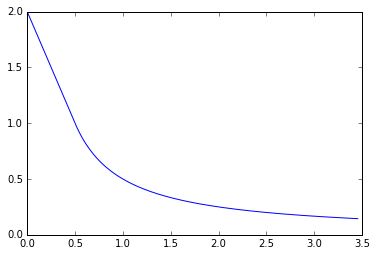

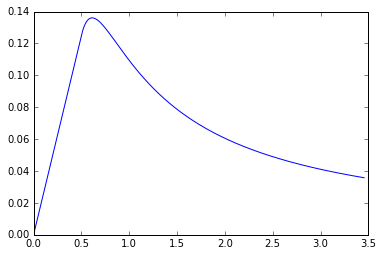

In [11]:
a=0.5
p=1
rijs = [np.array([x,x,x]) for x in  np.arange(0.005,2,0.005)]
RPYs = np.asarray([RotnePragerYamakawa(rij,a=a,p=p) for rij in rijs])
rs = [LA.norm(rij) for rij in rijs]
plt.plot(rs,RPYs[:,0,0])
plt.show()
plt.plot(rs,RPYs[:,0,2])
plt.show()

In [6]:
rtest = np.array([-5,5,0])
ptest = 1
atest = 1
RP = RotnePragerTracerPoly(rtest,ptest,atest)
R2pLR = longRangeR2p(rtest,ptest,atest)
R2pLRless = longRangeR2p(rtest,ptest,atest,2)
print('RP:',RP)
print('R2pLR:',R2pLR)
print('RP^-1:',LA.inv(RP))
print('diff:',(R2pLR)- (R2pLRless))

THIS CODE IS PROBABLY NOT CORRECT. USE getR() DEFINDE BELOW
THIS CODE IS PROBABLY NOT CORRECT. USE getR() DEFINDE BELOW
RP: [[ 0.07946112 -0.02625134  0.        ]
 [-0.02625134  0.07946112  0.        ]
 [ 0.          0.          0.05320979]]
R2pLR: [[ 1.40102569  0.17107833  0.17107833]
 [ 0.17107833  1.40102569  0.17107833]
 [ 0.17107833  0.17107833  1.40102569]]
RP^-1: [[ 14.1265791    4.66695661   0.        ]
 [  4.66695661  14.1265791    0.        ]
 [  0.           0.          18.79353571]]
diff: [[ 0.02325069  0.01050333  0.01050333]
 [ 0.01050333  0.02325069  0.01050333]
 [ 0.01050333  0.01050333  0.02325069]]


In [7]:
rtest = np.array([-2,2,2])
ptest = 1
atest = 1
RP = RotnePragerTracerPoly(rtest,ptest,atest)
print('RP:',RP)
print('R2pLR:',longRangeR2p(
        rtest,ptest,atest))
print('RP^-1:',LA.inv(RP))
print('R2pLR^-1:',LA.inv(R2pLR))

RP: [[ 0.14433757 -0.03458088 -0.03458088]
 [-0.03458088  0.14433757  0.03458088]
 [-0.03458088  0.03458088  0.14433757]]
THIS CODE IS PROBABLY NOT CORRECT. USE getR() DEFINDE BELOW
R2pLR: [[ 6.44534547  2.40092996  2.40092996]
 [ 2.40092996  6.44534547  2.40092996]
 [ 2.40092996  2.40092996  6.44534547]]
RP^-1: [[ 7.63532642  1.47573536  1.47573536]
 [ 1.47573536  7.63532642 -1.47573536]
 [ 1.47573536 -1.47573536  7.63532642]]
R2pLR^-1: [[ 0.73324977 -0.07979316 -0.07979316]
 [-0.07979316  0.73324977 -0.07979316]
 [-0.07979316 -0.07979316  0.73324977]]


In [8]:
c1 = 2
mmax = 5
c1pows = np.zeros(mmax)
c1pows[0] = 1;
for m in range(1,mmax):
    c1pows[m] = c1 * c1pows[m-1];
        
print(c1pows)


[  1.   2.   4.   8.  16.]


In [4]:


def h(m):
    if m==2: 
        return -2
    else: 
        return m-2

def f(k,lam):
    return 2**k * np.sum([P(1,k-q,q) * lam**q for q in range(0,k+1)])

def P(n,p,q):
    if (p,q)==(0,0): return 0
    else:
        return 

def getR(rij,a,p,mmax = 6,getPrefactors=False,getTest=False,getXY=False):
    r = LA.norm(rij)
    rrout = np.outer(rij,rij) / (r*r)
    lam = a/p
    lampow = [lam**i for i in range(12)]
    s = 2*r/(p/2 + a/2);
    
    cg = (1+lam)**(-3);
    
    f0 = 1;
    f1 = 3*lam;
    f2 = 9*lam;
    f3 = -4*lam+27*lampow[2]-4*lampow[3];
    f4 = -24*lam + 81*lampow[2] + 36*lampow[3];
    f5 = 72*lampow[2] + 243*lampow[3] + 72*lampow[4];
    f6 = 16*lam + 108*lampow[2]+ 281*lampow[3] + 648*lampow[4]+ 144*lampow[5];
    f7 = 1;
    f8 = 576*lampow[2] + 4848*lampow[3]+ 5409*lampow[4] + 4524*lampow[5] + 3888*lampow[6]+ 576*lampow[7];
    f9 = 1;
    f10 = 2304*lampow[2] + 20736*lampow[3]+ 42804*lampow[4]+ 115849*lampow[5]+ 76176*lampow[6] + 39264*lampow[7]+ 20736*lampow[8] + 2304*lampow[9];

    _fXm =  [f0,f2,f4,f6,f8,f10];

    fy0 = 1;
    fy2 = 9/4*lam;
    fy4 = 6*lam+81/16*lampow[2]+ 18*lampow[3];
    fy6 = 4*lam + 54*lampow[2]+ 1241/64 *lampow[3 ]+ 81*lampow[4] + 72*lampow[5];
    fy8 = 279*lampow[2] + 4261/8*lampow[3] + 126369/256*lampow[4] - 117/8*lampow[5] + 648*lampow[6] + 288*lampow[7];
    fy10 = 1152*lampow[2] +7857/4*lampow[3] +98487/16*lampow[4] + 10548393/1024*lampow[5] +67617/8*lampow[6] - 351/2*lampow[7 ]+ 3888*lampow[8] + 1152*lampow[9];
    _fYm =  [fy0,fy2,fy4,fy6,fy8,fy10]
    

    _gX = np.zeros(3)
    _gX[0] = 2 * lam**2 * cg;
    _gX[1] = lam/5 * ( 1 + 7*lam + lam*lam ) * cg;
    _gX[2] = 1/42 * ( 1 + lam*18 - lam**2*29 + lam**3*18 + lam**4) * cg;

    _gY = np.zeros(3)
    _gY[1] = 4./15 * lam * (2 + lam + 2*lam**2) * cg;
    _gY[2] = 2./375 * ( 16 - 45*lam + 58*lam**2 - 45*lam**3 + 16*lam**4) * cg;
    
    X=_gX[0]*(1-4*s**(-2))**-1  -  _gX[1]*np.log(1-4*s**(-2))  -  _gX[2]*(1-4*s**(-2))*np.log(1-4*s**(-2))  +  f0  -  _gX[0] + sum(
        [(2**(-m) * (1+lam)**(-m) *_fXm[int(m/2+0.0001)] - _gX[0] - 2/m*_gX[1] + 4/m /h(m) * _gX[2])*(2/s)**m for m in range(2,2*mmax,2)]) 
    
    Y=-_gY[1]*np.log(1-4*s**(-2)) - _gY[2]*(1-4*s**(-2))*np.log(1-4*s**(-2))  +  fy0  + sum(
        [(2**(-m) * (1+lam)**(-m) *_fYm[int(m/2+0.0001)] - 2/m*_gY[1] + 4/m /h(m) * _gY[2])*(2/s)**m for m in range(2,2*mmax,2)]) 
    
    if getTest:
        return _gX[1]*np.log(1-4*s**(-2)) - sum([ (- 2/m*_gX[1])*(2/s)**m for m in range(2,2*mmax,2)]),  _gX[2]*(1-4*s**(-2))*np.log(1-4*s**(-2)) - sum([ ( 4/m /h(m) * _gX[2])*(2/s)**m for m in range(2,2*mmax,2)])
    
    if getPrefactors==True:
        return Y, X-Y
    
    if getXY:
        print(s)
        print(_gY)
        print(_gX)
        print(_fYm)
        print(_fXm)
        tmp=[]
        for m,x in enumerate(_fYm):
            tmp.append(x*(2**(-2*m) * (1+lam)**(-2*m)))
        print(tmp)
        tmp=[]
        for m,x in enumerate(_fXm):
            tmp.append(x*(2**(-2*m) * (1+lam)**(-2*m)))
        print(tmp)
        return X,Y
    
    return X * rrout + Y * (np.identity(3) - rrout)
        
               
    

In [3]:
a=1
p=1
rij = np.array([(a+p)/2.,0,0.1])
(getR(rij,a=a,p=p,getXY=True))

2.00997512422
[ 0.          0.16666667  0.        ]
[ 0.25        0.225       0.02678571]
[1, 2.25, 29.0625, 230.390625, 2226.62890625, 32889.4775390625]
[1, 9.0, 93.0, 1197.0, 19821.0, 320173.0]
[1.0, 0.140625, 0.113525390625, 0.056247711181640625, 0.03397566080093384, 0.03136585000902414]
[1.0, 0.5625, 0.36328125, 0.292236328125, 0.3024444580078125, 0.3053407669067383]


(27.095768103414645, 1.7644089800017491)

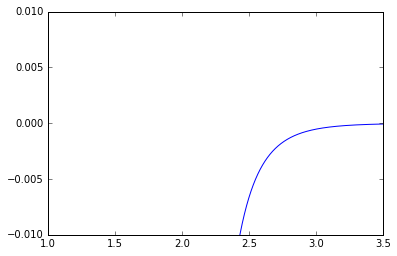

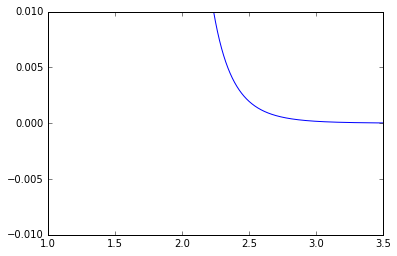

In [151]:
a=10
p=1
rijs = [np.array([(a+p)/2.+x/(a+p),0.0001,0.0001]) for x in np.arange(0.001,20*(a+p),0.01)]
Rs = [LA.norm(rij)*4/(a+p) for rij in rijs]
R2prefs = np.array([getR(rij,a=a,p=p,getTest=True) for rij in rijs])
plt.plot(Rs,R2prefs[:,0],label='R2')
plt.ylim([-0.01,0.01])
plt.xlim([1,3.5])
plt.show()

plt.plot(Rs,R2prefs[:,1],label='R2')
plt.ylim([-0.01,0.01])
plt.xlim([1,3.5])
plt.show()

#### compare result of getR() to inverted RP at to check if lubrication is calculated (somewhat) correctly.

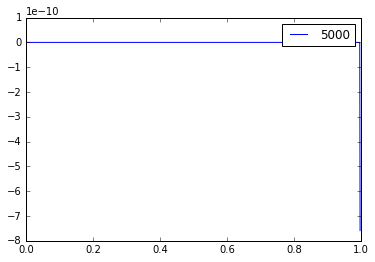

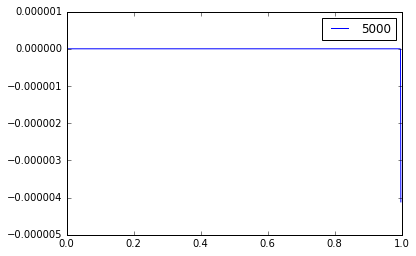

2.23606797749979

In [115]:
xs = np.arange(0,0.999,0.001)
def lnTayl(x,M):
    return (np.log(1-x) + sum([x**m /m for m in range(1,M)]))
def lnTayl2(x,M):
    return (-(1-x)*np.log(1-x) + sum([2*x**m /m/h(2*m) for m in range(1,M)]))
M=5000
plt.plot(xs,lnTayl2(xs,M),label=str(M))
#plt.ylim([-0.1,0])
plt.legend()
plt.show()
plt.plot(xs,lnTayl(xs,M),label=str(M))
#plt.xlim([])
plt.legend()
plt.show()
2./0.8**0.5

In [50]:
M=4
x=1
[x**m /m for m in range(1,M)]

[1.0, 0.5, 0.3333333333333333]

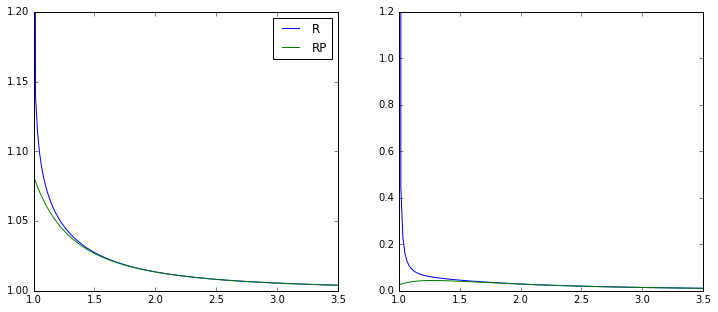

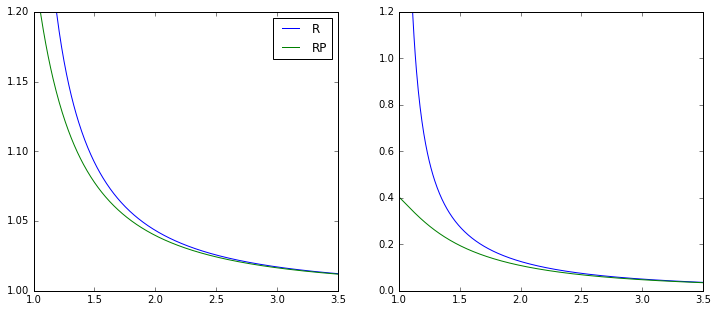

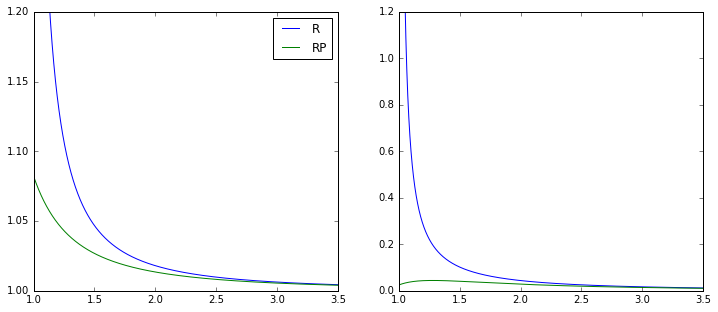

In [41]:
def getInvRP(rvec,p,a,i=0,j=0,full=False):
    RP2p = np.identity(6)
    RP2p[0:3,3:] = RotnePragerTracerPoly(rvec, p, a=a)
    RP2p[3:,0:3] = RotnePragerTracerPoly(rvec, p, a=a)
    RP2p[3:,3:] = np.identity(3) * p/a
    if full:
        return (LA.inv(RP2p)[:3,:3])
    return (LA.inv(RP2p)[:3,:3])[i,j]

def getRPprefactors(rij,p,a):    
    rr = np.outer(rij,rij) / rij.dot(rij)
    pref_rr = getInvRP(rij,p,a,0,1) / rr[0,1]   # This is correct!
    pref_I = (getInvRP(rij,p,a,0,0) - pref_rr * rr[0,0])
    return pref_I, pref_rr



p=1;
for a in [0.1,1,10]:
    plt.figure(1,figsize=(12,5))
    rijs = [np.array([(a+p)/2.+x/(a+p),0.0001,0.0001]) for x in np.arange(0,20*(a+p),0.01)]
    Rs = [LA.norm(rij)*2/(a+p) for rij in rijs]
    Rprefs = np.array([getR(rij,a=a,p=p,getPrefactors=True) for rij in rijs])
    invRPprefs = np.array([getRPprefactors(rij,p=p,a=a) for rij in rijs])
    plt.subplot(121)
    plt.plot(Rs,Rprefs[:,0],label='R')
    plt.plot(Rs,invRPprefs[:,0],label='RP')
    #plt.plot(Rs,abs(invRPprefs[:,0]-Rprefs[:,0]))
    plt.ylim([1,1.2])
    plt.xlim([1,3.5])
    plt.legend()
    plt.subplot(122)
    plt.plot(Rs,Rprefs[:,1])
    plt.plot(Rs,invRPprefs[:,1])
    # plt.plot(Rs,abs(invRPprefs[:,1]-Rprefs[:,1]))
    plt.ylim([0,1.2])
    plt.xlim([1,3.5])
    plt.show()

# a=1;p=1;rij= np.array([1,0,1])
# print('test:',getR(rij,a=a,p=p,getPrefactors=True))

# make np.arange for distances R
# Ys = Prefactors[:,0]
# prefrr = X - Y  --> X = prefrr + Y
# Xs = Prefactors[:,0] + Ys
# plt.plot(Rs,Xs)
# plt.show()

# plt.plot(Rs,Ys)
# plt.show()

In [47]:
# RP for touching spheres
a=1
ps=np.arange(0.1,10,0.1)
rijs=[np.array([(a+p)/2,0,0]) for p in ps]
prefs=np.array([RotnePragerPolyPoly(rij,p=p,a=a) for rij in rijs])
print(prefs)
# plt.plot(ps,prefs[:,0])
# plt.plot(ps,prefs[:,1])

[[[ 0.61232156  0.          0.        ]
  [ 0.          1.05747558  0.        ]
  [ 0.          0.          1.05747558]]

 [[ 0.6712963   0.          0.        ]
  [ 0.          0.91435185  0.        ]
  [ 0.          0.          0.91435185]]

 [[ 0.69868002  0.          0.        ]
  [ 0.          0.80450614  0.        ]
  [ 0.          0.          0.80450614]]

 [[ 0.70699708  0.          0.        ]
  [ 0.          0.71793003  0.        ]
  [ 0.          0.          0.71793003]]

 [[ 0.7037037   0.          0.        ]
  [ 0.          0.64814815  0.        ]
  [ 0.          0.          0.64814815]]

 [[ 0.69335937  0.          0.        ]
  [ 0.          0.59082031  0.        ]
  [ 0.          0.          0.59082031]]

 [[ 0.67881132  0.          0.        ]
  [ 0.          0.54294728  0.        ]
  [ 0.          0.          0.54294728]]

 [[ 0.66186557  0.          0.        ]
  [ 0.          0.50240055  0.        ]
  [ 0.          0.          0.50240055]]

 [[ 0.64367984  0.      

# Calculate mobility from lubrication only for mobile tracer (p) and immobile spheres (a)

In [6]:
rvec = np.array([1,2,1])
p=1; a=1
RP2p = np.identity(6)
RP2p[0:3,3:] = RotnePragerTracerPoly(rvec, p, a=a)
RP2p[3:,0:3] = RotnePragerTracerPoly(rvec, p, a=a)
R_RP = LA.inv(RP2p)
print(R_RP[:3,:3])
print(getR(rvec,a=a,p=p))
print(getR(rvec,a=a,p=p)-R_RP[:3,:3])

[[ 1.03736013  0.02394792  0.01197396]
 [ 0.02394792  1.07328202  0.02394792]
 [ 0.01197396  0.02394792  1.03736013]]
[[ 1.03998096  0.02619725  0.01309862]
 [ 0.02619725  1.07927683  0.02619725]
 [ 0.01309862  0.02619725  1.03998096]]
[[ 0.00262083  0.00224932  0.00112466]
 [ 0.00224932  0.00599481  0.00224932]
 [ 0.00112466  0.00224932  0.00262083]]


In [7]:
def gettracerMlub(rijs,a,p):
    selfR = np.zeros([3,3])
    for rij in rijs:
        selfR += getR(rij,a=a,p=p)
    return LA.inv(selfR)
lam = 1
p = 1
a = lam*p
ras = []
# create particle test distance vectors - 1 rod
for i in range(1,10):
    ras.append([a*i,0,0])
    ras.append([0,a*i,0])
    ras.append([0,0,a*i])
rp = np.array([5,5,5])
rijs = [rp-ra for ra in ras]
print(rijs)
print(gettracerMlub(rijs[:1],a,p))

[array([4, 5, 5]), array([5, 4, 5]), array([5, 5, 4]), array([3, 5, 5]), array([5, 3, 5]), array([5, 5, 3]), array([2, 5, 5]), array([5, 2, 5]), array([5, 5, 2]), array([1, 5, 5]), array([5, 1, 5]), array([5, 5, 1]), array([0, 5, 5]), array([5, 0, 5]), array([5, 5, 0]), array([-1,  5,  5]), array([ 5, -1,  5]), array([ 5,  5, -1]), array([-2,  5,  5]), array([ 5, -2,  5]), array([ 5,  5, -2]), array([-3,  5,  5]), array([ 5, -3,  5]), array([ 5,  5, -3]), array([-4,  5,  5]), array([ 5, -4,  5]), array([ 5,  5, -4])]
[[ 0.99630069 -0.00193376 -0.00193376]
 [-0.00193376  0.9954305  -0.0024172 ]
 [-0.00193376 -0.0024172   0.9954305 ]]


### Compare to RP

In [8]:
def gettracerMRP(rvecs,a,p):
    dim = len(rvecs)
    M = np.zeros([3*dim,3*dim])
    for i in range(dim):
        for j in range(i,dim):
            ic = 3*i
            jc = 3*j
            if (i==j): 
                M[ic:ic+3,ic:ic+3] = p/a * np.identity(3)
            else:
                M[ic:ic+3,jc:jc+3] = RotnePragerTracerPoly(rvecs[i]-rvecs[j],a=a,p=p)
                M[jc:jc+3,ic:ic+3] = np.copy(M[ic:ic+3,jc:jc+3])
    M[0:3,0:3] =  np.identity(3)
    np.set_printoptions(threshold=100000)
    print((M.transpose() == M).all())
    return LA.inv(LA.inv(M)[:3,:3])
print(gettracerMRP(np.asarray([rp] + ras), p=p, a=a))

True
[[ 0.96144098 -0.00950846 -0.00950846]
 [-0.00950846  0.96144098 -0.00950846]
 [-0.00950846 -0.00950846  0.96144098]]


_________
_________
### Check if two-particle RP inverted is really just 3x3 identity matrix
To add  lubrication I have to add the two-particle resistance function $R_{2p}$ and subtract the long-range part that is already included in the RP tensor $R_{2p}^{RP}$ 
I assumed that for the subtraction of the long-range Part of the lubrication $R_{2p}^{RP}$  I just need to subtract the RP self mobility of the tracer, which, in my simulation, is just the identity matrix.

But, I need to verify that, if I invert the $6{\times}6$ two-particle RP tensor, I really just obtain the unit matrix as the self-resistance of the tracer, i.e. the upper left $3{\times}3$ sub matrix of the inverted $6{\times}6$ RP tensor.

### Turns out, this assertion was wrong

In [20]:
rvec = np.array([1,0,0.001])
p=1; a=1
RP2p = np.identity(6)
RP2p[0:3,3:] = RotnePragerTracerPoly(rvec, p, a=a)
RP2p[3:,0:3] = RotnePragerTracerPoly(rvec, p, a=a)
print('Rotne-Prager:\n',RP2p)
R_RP = LA.inv(RP2p)
print('Rotne-Prager-Inverted:\n',(R_RP))
R2p = getR(rvec,a,p=p,mmax=6,shortRange=True)
print('R2p:\n',R2p)
R_RP_tracer = np.copy(R_RP[:3,:3])

lubTracer = R2p - R_RP_tracer
print('lubMinusRP:\n',lubTracer)
print('lubShortRange\n',getR(rvec,a,p=p,mmax=6,longRange=False))


print('Mobility from lubMinusRP:\n',LA.inv(lubTracer))
print('Mobility from lubShortRange:\n',LA.inv(getR(rvec,a,p=p,mmax=6,longRange=False)))

Rotne-Prager:
 [[  1.00000000e+00   0.00000000e+00   0.00000000e+00   6.24999625e-01
    0.00000000e+00   1.87499906e-04]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    4.37499719e-01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   1.87499906e-04
    0.00000000e+00   4.37499906e-01]
 [  6.24999625e-01   0.00000000e+00   1.87499906e-04   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.37499719e-01   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  1.87499906e-04   0.00000000e+00   4.37499906e-01   0.00000000e+00
    0.00000000e+00   1.00000000e+00]]
Rotne-Prager-Inverted:
 [[  1.64102461e+00   0.00000000e+00   4.04310006e-04  -1.02563984e+00
    0.00000000e+00  -4.84577549e-04]
 [  0.00000000e+00   1.23671460e+00   0.00000000e+00   0.00000000e+00
   -5.41062289e-01   0.00000000e+00]
 [  4.04310006e-04   0.00000000e+00   1.23671500e+00  -4.84577549e-04
    0.00000000e+00  -5.41062774e-0

# Fit Inverted RP Stuff

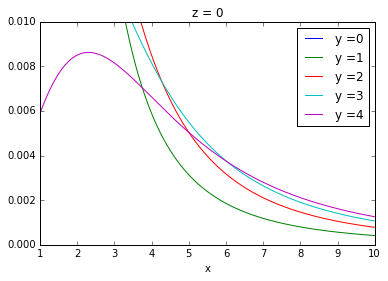

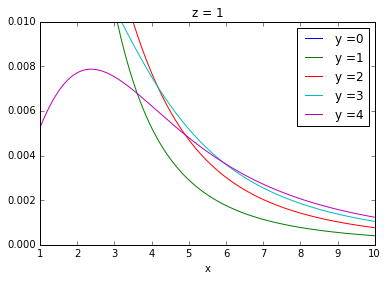

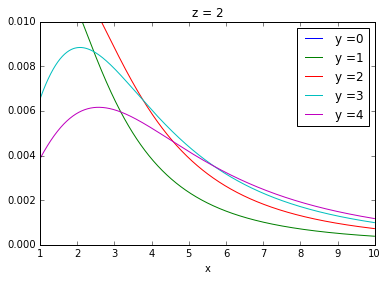

In [9]:
def getInvRP(rvec,p,a,i=0,j=0,full=False):
    RP2p = np.identity(6)
    RP2p[0:3,3:] = RotnePragerTracerPoly(rvec, p, a=a)
    RP2p[3:,0:3] = RotnePragerTracerPoly(rvec, p, a=a)
    RP2p[3:,3:] = np.identity(3) * p/a
    if full:
        return (LA.inv(RP2p)[:3,:3])
    return (LA.inv(RP2p)[:3,:3])[i,j]

rvec = lambda x,y,z: np.array([x,y,z])

getInvRR = np.vectorize(getInvRP)

p=1; a=1
xrange = np.arange((a+p)/2, 10,0.01)
for z in range(0,3):
    plt.figure(z)
    for y in range(0,5):
        RPparam = [getInvRP(rvec(x,y,z),p,a,1) for x in xrange ]
        plt.plot(xrange,RPparam,label='y =' + str(y))
    plt.title('z = ' + str(z))
    plt.ylim(0,.01)
    plt.xlabel('x')
    plt.legend()
    plt.show()



In [39]:
rij = rvec(1,2,1)
getInvRP(rij,p,a,full=True) / np.outer(rij,rij)

array([[ 1.03736013,  0.01197396,  0.01197396],
       [ 0.01197396,  0.2683205 ,  0.01197396],
       [ 0.01197396,  0.01197396,  1.03736013]])

### Find prefactors that only depend on the distance r

In [12]:
def getPrefactors(rij,p,a):    
    rr = np.outer(rij,rij) / rij.dot(rij)
    pref_rr = getInvRP(rij,p,a,0,1) / rr[0,1]   # This is correct!
    pref_I = (getInvRP(rij,p,a,0,0) - pref_rr * rr[0,0])
    return pref_I, pref_rr

#test if it works -- Yes!
rij = np.array([0.01,5,0])
a = 0.5; p = 1
# print(getInvRP(rij,p,a,full=True))
pI,prr = getPrefactors(rij,a,p)
print(getInvRP(rij,p,a,full=True) - np.identity(3)*pI - prr * np.outer(rij,rij))
print(getPrefactors(rij,a,p))
rij *=2; a *=2; p*=2
print(rij)
print(getPrefactors(rij,a,p))

[[ -8.10070223e-07  -4.05035111e-04   0.00000000e+00]
 [ -4.05035111e-04  -2.02517556e-01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -2.22044605e-16]]
(1.0028440405175796, 0.0084382300783921865)
[  0.02  10.     0.  ]
(1.0028440405175796, 0.0084382300783921865)


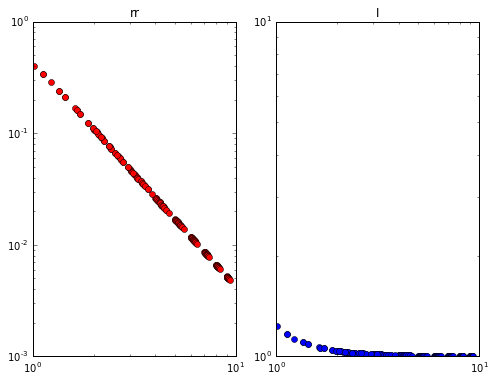

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 6))
pI_store = []
prr_store = []
r_store = []
a=1
p=1
for x in np.arange(0.1,2,0.4):
    for y in np.arange(0.1,2,0.4):
        for z in np.arange((a+p)/2,10):
            vec = np.array([x,y,z])
            r = LA.norm(vec)
            pI,prr = getPrefactors(vec,a=a,p=p)
            ax1.loglog(r,prr,'ro')
            ax2.loglog(r,pI,'bo')
            pI_store.append(pI)
            prr_store.append(prr)
            r_store.append(r)
ax1.set_title('rr')
ax2.set_title('I')
plt.show()

### Power Law fits to rr prefactor

[]

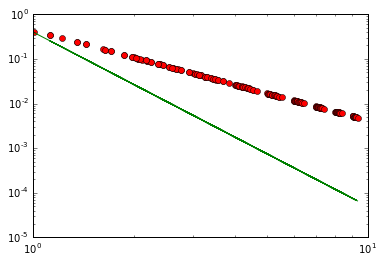

In [14]:
def fitres(r):
    r=np.array(r)
    return 0.4*r**np.log10(5e-5/0.4)

plt.loglog(r_store,prr_store,'ro')
plt.loglog(r_store,fitres(r_store),'-g')
plt.plot()

### What fits for I prefactor?
Looks like an exponential decrease. If I have a look at what the lubrication tensor looks like
\begin{equation}
 {A}_{ij} =   \hat{r} \hat{r} \left( X_{ij} - Y_{ij} \right) + {1} X_{ij} 
\end{equation}
the I part prefactor $X_{ij}$ is actually a polynomial 
$$X_{11}(s,\lambda) \propto \sum_{\substack{m = 2 \\ m \text{ even}}} P_m \left(\frac{2}{s}\right)^m$$

In [17]:
def fpoly(x, a, b, c, d, e, f, g, h):
    x = np.asarray(x)
    return a + b*x**-1 + c*x**-2 + d*x**-3 + e*x**-4 + f*x**-5 + g*x**-6 + h*x**-7


###################################
## fpoly2 leads to same good fit ##
####################################
def fpoly2(x, a, b, c, d, e, f, g, h):
    x = np.asarray(x)
    return a + b*x**-2 + c*x**-4 + d*x**-6 + e*x**-8 + f*x**-10 + g*x**-12 + h*x**-14

def fpow(x,a,b):
    return a * x**b

fitI, pcov = curve_fit(fpoly, r_store, pI_store)
fitrr, pcov = curve_fit(fpow, r_store, prr_store, p0=(0.4, np.log10(5e-5/0.4)))
print(fitI)
print(fitrr)

[ 0.9999458   0.00137232  0.12690813  0.07054982 -0.13717103  0.33596445
 -0.27998603  0.11912424]
[ 0.42512725 -1.97715673]


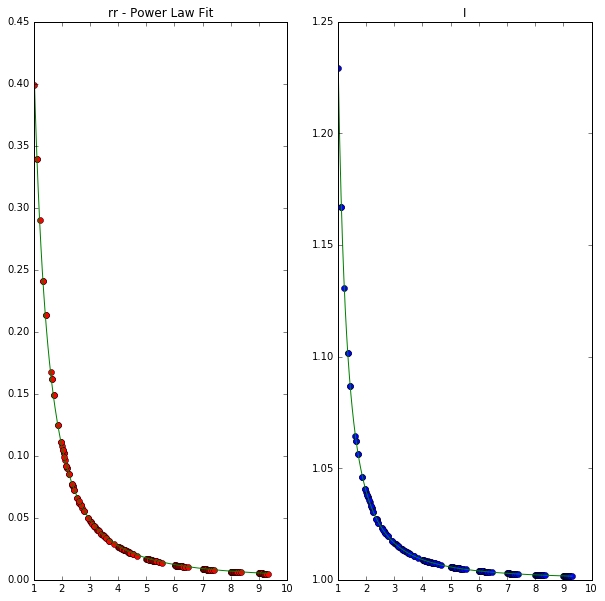

In [18]:
xs = np.arange(r_store[0],r_store[-1],0.05)
ysI = fpoly(xs, *fitI)
ysrr = fpow(xs, *fitrr)
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 10))
ax1.plot(r_store,prr_store,'ro')
ax1.plot(xs,ysrr,'g-')
ax2.plot(r_store,pI_store,'bo')
ax2.plot(xs,ysI,'g-')
ax1.set_title('rr - Power Law Fit')
ax2.set_title('I')
plt.show()

Finally test polynomial fit also with rr prefactor

[  7.35680644e-05  -1.91834824e-03   4.41809663e-01  -1.07872832e-01
   3.95238502e-01  -5.99041338e-01   5.66146181e-01  -2.90121832e-01] 
We can see  that, in accordance with the power law fit, the prefactor of the x**-4 term dominates.


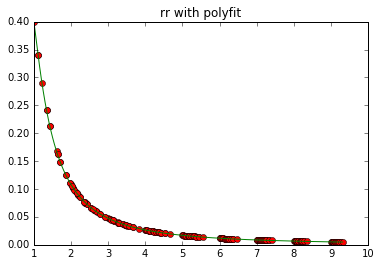

In [19]:
fitrrPoly, pcov = curve_fit(fpoly, r_store, prr_store)
ysrrPoly = fpoly(xs, *fitrrPoly)
plt.plot(r_store,prr_store,'ro')
plt.plot(xs,ysrrPoly,'g-')
plt.title('rr with polyfit')
print(fitrrPoly, '\nWe can see  that, in accordance with the power law fit, the prefactor of the x**-4 term dominates.')

Maybe even a tiny bit better than power law fit.

## Now I need to test with different a and p
### Rescaling the variables as in Jeffrey1984
\begin{equation}
s = \frac{2r}{a + p}, \quad \lambda = \frac{a}{p}
\end{equation}

In [27]:
def fitRPinv(a,p,plot=True,plotall=False):
    # First, we need to find the prefactors pI and prr of the identity Matrix I and the outer product rr
    # for different sphere distances r.
    pI_store = []
    prr_store = []
    s_store = []
    r_store = []
    gets = lambda r: 4*r/(a+p)
    lam = a/p 
    #TODO change this so simply an r array or something, since the results only depend on r not on the vector
    for x in np.arange(0.001,15*(a+p)/2,0.025*(a+p)):
        vec = np.array([x,0.00000001,(a+p)/2])
        r = LA.norm(vec)
        s = gets(r)
        pI,prr = getPrefactors(vec,a=a,p=p)
        pI_store.append(pI)
        prr_store.append(prr)
        r_store.append(r)
        s_store.append(s)
    if plotall and plot:
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 6))
        ax1.loglog(r_store,prr_store,'ro')
        ax2.loglog(r_store,pI_store,'bo')
        ax1.set_title('rr')
        ax2.set_title('I')
        plt.show()
    # Then we need to fit the result. For now only a polyfit.
    fitI, pcov = curve_fit(fpoly, s_store, pI_store)
    fitrr, pcov = curve_fit(fpoly, s_store, prr_store)
    if plot:
        print(fitI)
        print(fitrr)
        xs = np.arange(s_store[0],s_store[-1],0.05)
        ysI = fpoly(xs, *fitI)
        ysrr = fpoly(xs, *fitrr)
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
        ax1.plot(s_store,prr_store,'ro')
        line1 = ax1.plot(xs,ysrr,'g-')
        ax2.plot(s_store,pI_store,'bo')
        line2 = ax2.plot(xs,ysI,'g-')
        plt.setp([line1,line2], linewidth=3, color='g')
        ax1.set_title('rr')
        ax2.set_title('I')
        ax1.set_xlabel('s')
        ax2.set_xlabel('s')
        ax1.set_ylabel('prefactor of $rr$')
        ax2.set_ylabel('prefactor of $I$')
        plt.legend()
    return lam, fitI, fitrr

[  9.99968521e-01   1.97469240e-03   5.16279283e-01   5.29099905e-01
  -2.20148649e+00   1.11774216e+01  -1.89866204e+01   1.60655813e+01]
[  3.64193634e-05  -2.36297844e-03   1.74543610e+00  -7.05274209e-01
   5.71275554e+00  -1.78846389e+01   3.48640869e+01  -3.65626594e+01]
[  9.99973971e-01   1.63352241e-03   4.61741253e-01   4.38338977e-01
  -1.71988076e+00   9.28754276e+00  -1.57387812e+01   1.34569065e+01]
[ -9.28038716e-06   5.38679185e-04   1.48892098e+00   1.00684074e-01
  -3.31919161e-01  -2.26919793e-02   3.28704969e-01  -1.08567311e+01]
[  9.99973971e-01   1.63352241e-03   4.61741253e-01   4.38338977e-01
  -1.71988076e+00   9.28754276e+00  -1.57387812e+01   1.34569065e+01]
[ -9.28038716e-06   5.38679185e-04   1.48892098e+00   1.00684074e-01
  -3.31919161e-01  -2.26919793e-02   3.28704969e-01  -1.08567311e+01]
[  9.99968509e-01   1.97534102e-03   5.16266255e-01   5.29227033e-01
  -2.20215046e+00   1.11793117e+01  -1.89893776e+01   1.60671912e+01]
[  3.64233573e-05  -2.36318

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


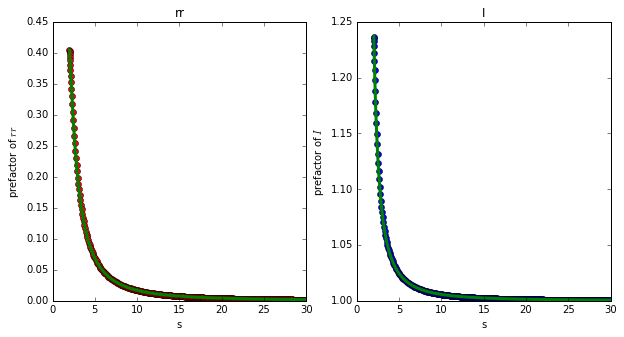

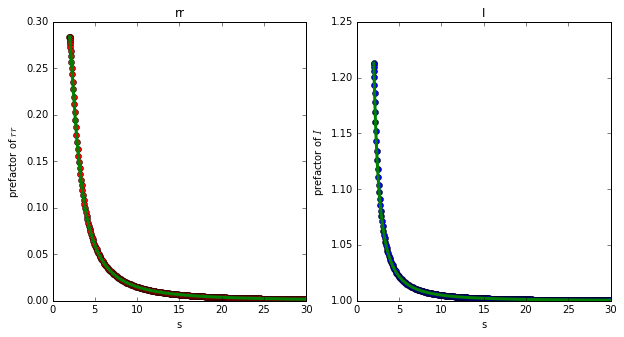

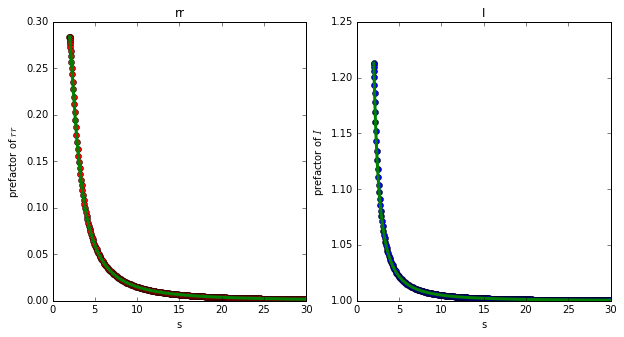

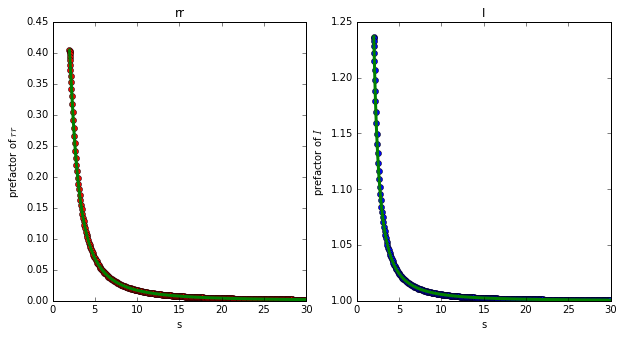

In [28]:
for a in range(1,3):
    for p in range(1,3):
        fitRPinv(a=a,p=p)

## Now I need to look for a fit function for the lambda dependency

In [29]:
p = 1
lams = []
rfitpIs = []
rfitprrs = []
for a in np.arange(0.1,10,0.1): #This creates lams = a, if p=1
    lam, rfitpI, rfitprr = fitRPinv(a=a,p=p,plot=False) # Fit in r, i.e. s, to obtain stützstellen for fit in lambda 
#     print(rfitpI,'\n------------------------\n')
    lams.append(lam)
    rfitpIs.append(rfitpI)
    rfitprrs.append(rfitprr)
rfitpIs = np.asarray(rfitpIs).T
rfitprrs = np.asarray(rfitprrs).T

### Try fit like before, since results seem to deviate towards small lambda
(looks bad)

[array([  1.00000728e+00,  -1.09828771e-04,   1.10257013e-04,
        -4.92659266e-05,   1.03645612e-05,  -7.62715102e-07,
        -3.25567749e-08,   4.45106264e-09]), array([ -4.57420047e-04,   6.91408160e-03,  -6.99454785e-03,
         3.18206874e-03,  -6.99814973e-04,   6.10479129e-05,
         4.09467994e-07,  -2.06720019e-07]), array([  3.40072278e-02,   1.74011633e+00,  -2.52639787e+00,
         1.89653644e+00,  -7.93493899e-01,   1.80354644e-01,
        -2.02407541e-02,   8.47907792e-04]), array([ -1.22038412e-01,   1.86324885e+00,  -1.90919186e+00,
         8.91814876e-01,  -2.07691128e-01,   2.15086076e-02,
        -5.08954709e-04,  -2.84344460e-05]), array([  8.84416212e-01,  -7.69429733e+00,   5.60656600e+00,
        -4.49626382e-01,  -9.51391344e-01,   3.91964115e-01,
        -5.69426074e-02,   2.72252320e-03]), array([ -2.55505652e+00,   3.97945222e+01,  -4.17607783e+01,
         2.04385680e+01,  -5.21071426e+00,   6.64534287e-01,
        -3.59958344e-02,   4.99290584e-04]

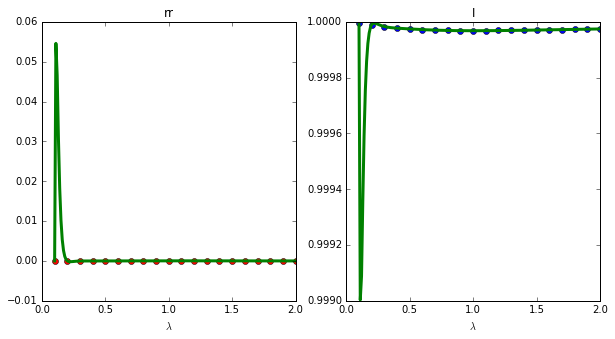

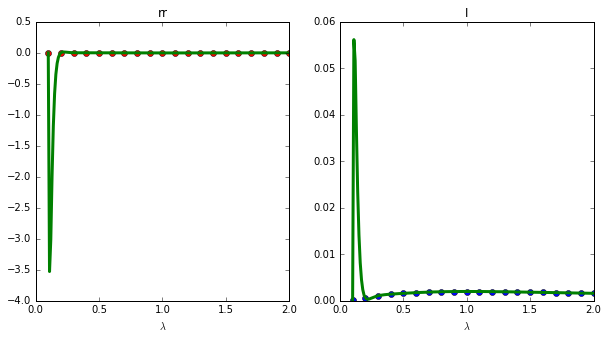

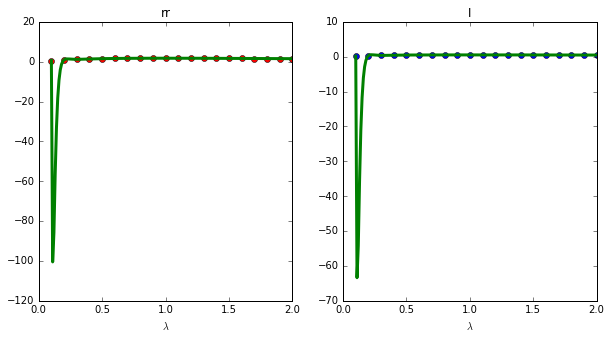

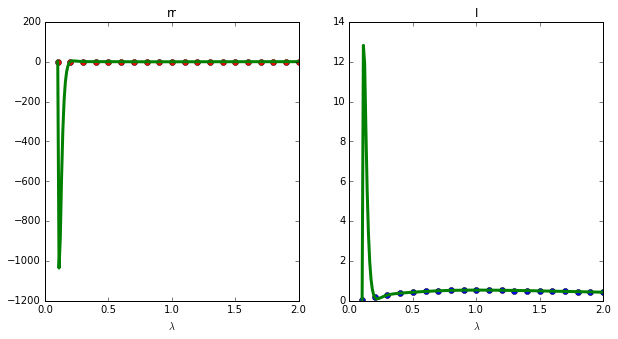

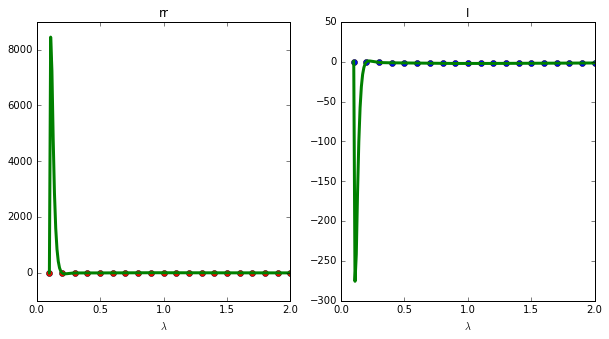

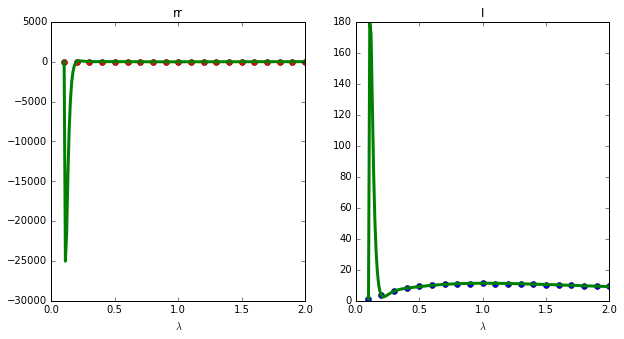

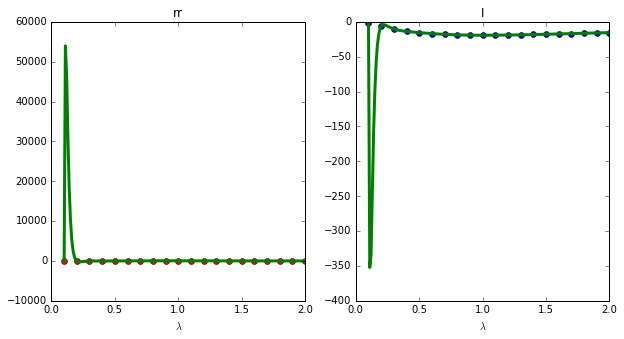

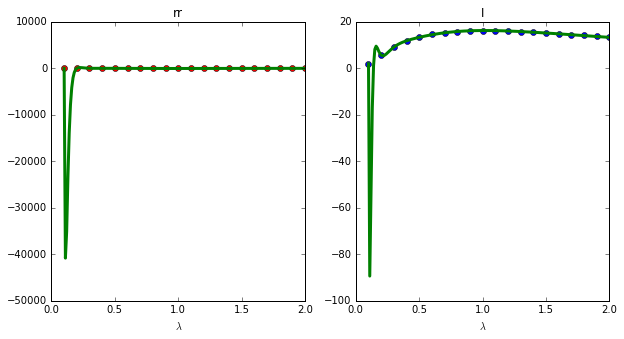

In [30]:
# Fit the prefactors p[i] with to polynomial function in lambda
lamfitpIs = []
lamfitprrs = []
for pI in rfitpIs:
    fit, pcov = curve_fit(fpoly, lams, pI)
    lamfitpIs.append(fit)
for prr in rfitprrs:
    fit, pcov = curve_fit(fpoly, lams, prr)
    lamfitprrs.append(fit)
print(lamfitpIs)
print(lamfitprrs)
xs = np.arange(lams[0],lams[-1],0.01)
polys = []
#Plot fit results
for i in range(len(lamfitprrs)):
    ysI = fpoly(xs, *lamfitpIs[i])
    ysrr = fpoly(xs, *lamfitprrs[i])
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
    ax1.plot(lams,rfitprrs[i],'ro')
    line1 = ax1.plot(xs,ysrr,'g-')
    ax2.plot(lams,rfitpIs[i],'bo')
    line2 = ax2.plot(xs,ysI,'g-')
    plt.setp([line1,line2], linewidth=3, color='g')
    ax1.set_title('rr')
    ax2.set_title('I')
    ax1.set_xlabel(r'$\lambda$')
    ax2.set_xlabel(r'$\lambda$')
    ax1.set_xlim([0,2])
    ax2.set_xlim([0,2])



### Try polymer fit
looks ok - which is a surprise, since i forgot $(1 - \lambda)^{-2k}$ term, when I chose the fit function

[array([  5.45855736e-14,  -4.24229226e-12,   1.49200725e-10,
        -3.13957458e-09,   4.40316342e-08,  -4.33891335e-07,
         3.08510135e-06,  -1.59955282e-05,   6.03513134e-05,
        -1.63265087e-04,   3.06549128e-04,  -3.73500253e-04,
         2.46964110e-04,  -1.71660220e-05,  -8.33996093e-05,
         1.00000521e+00]), array([ -3.42417738e-12,   2.66042120e-10,  -9.35356387e-09,
         1.96751030e-07,  -2.75824700e-06,   2.71676123e-05,
        -1.93071805e-04,   1.00045659e-03,  -3.77222634e-03,
         1.01966084e-02,  -1.91251177e-02,   2.32636868e-02,
        -1.53228769e-02,   9.77991442e-04,   5.25695423e-03,
        -3.27088577e-04]), array([  2.47124613e-10,  -1.94802708e-08,   6.96806808e-07,
        -1.49666229e-05,   2.15291912e-04,  -2.19046651e-03,
         1.62328074e-02,  -8.89320685e-02,   3.62081079e-01,
        -1.09351189e+00,   2.43203571e+00,  -3.94104123e+00,
         4.59825222e+00,  -3.79655008e+00,   2.01566373e+00,
         1.37466438e-02]), arr

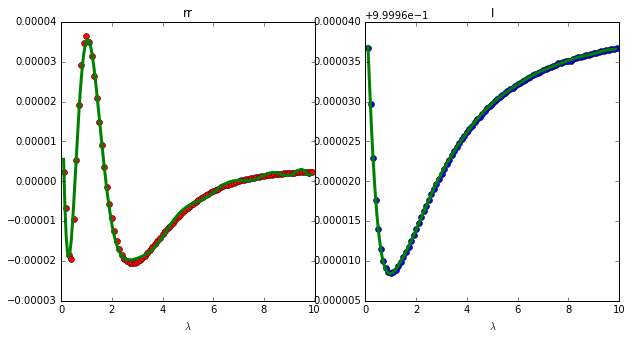

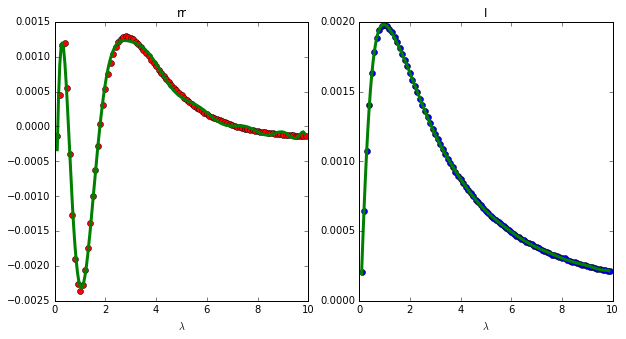

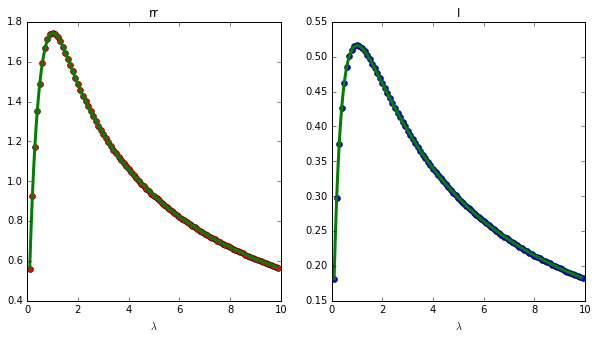

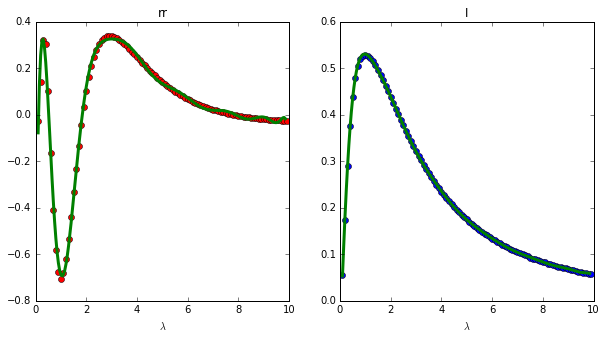

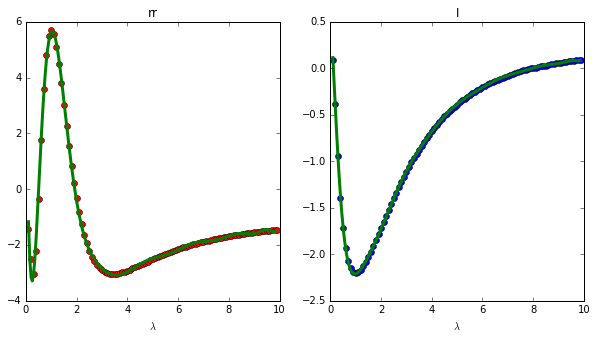

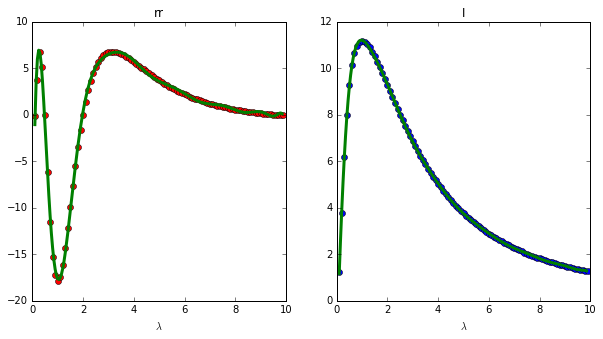

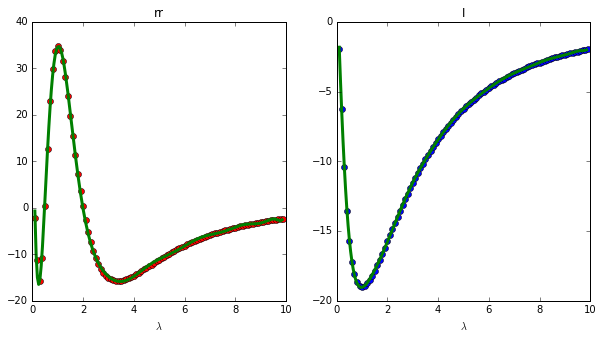

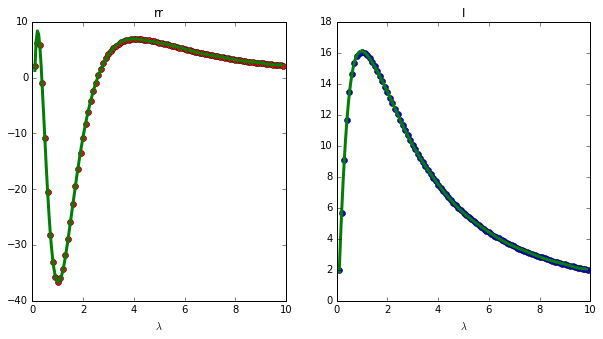

In [31]:
lamfitpIs = []
lamfitprrs = []
npoly = 15 # polymer order
for pI in rfitpIs:
    fit = np.polyfit(lams, pI, npoly)
    lamfitpIs.append(fit)
for prr in rfitprrs:
    fit = np.polyfit(lams, prr, npoly)
    lamfitprrs.append(fit)
print(lamfitpIs)
print(lamfitprrs)
xs = np.arange(lams[0],lams[-1],0.05)
polys = []
#Plot fit results
for i in range(len(lamfitprrs)):
    prr = np.poly1d(lamfitprrs[i])
    pI = np.poly1d(lamfitpIs[i])
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
    ax1.plot(lams,rfitprrs[i],'ro')
    line1 = ax1.plot(xs,prr(xs),'g-')
    ax2.plot(lams,rfitpIs[i],'bo')
    line2 = ax2.plot(xs,pI(xs),'g-')
    plt.setp([line1,line2], linewidth=3, color='g')
    ax1.set_title('rr')
    ax2.set_title('I')
    ax1.set_xlabel(r'$\lambda$')
    ax2.set_xlabel(r'$\lambda$')


### Conclusion
The $\sum_m p_m(\lambda) s^{-m}$ and $\sum_n c_n \lambda^{-n}$ fit results look quite usable.

Try it for examplary $\lambda$

In [32]:
# Function that returns the prefactors for the polymer to calculate the RP resistance matrix for a certain lambda
def getps(lam):
    pIs = []; prrs = []
    for i in range(len(lamfitprrs)):
#         pIs.append(fpoly(lam, *lamfitpIs[i]))
#         prrs.append(fpoly(lam, *lamfitprrs[i]))
          prrs.append(np.poly1d(lamfitprrs[i])(lam))
          pIs.append(np.poly1d(lamfitpIs[i])(lam))
    return pIs, prrs

def getRPinvFIT(rvec,a,p):
    lam = a/p
    s = 4*np.sqrt(rvec.dot(rvec)) / (a+p)
    pIs, prrs = getps(lam)
    return np.identity(3) * fpoly(s, *pIs)  + np.outer(rvec,rvec)/rvec.dot(rvec) * fpoly(s, *prrs)


lambda =  1.2


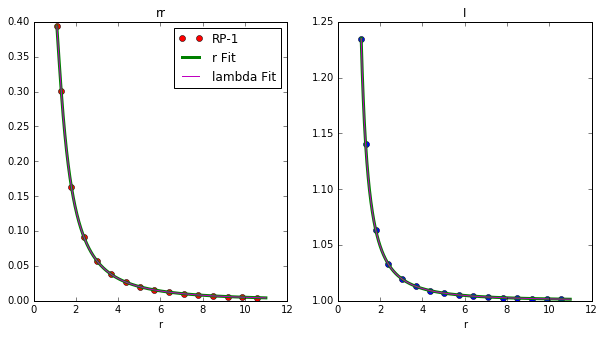

In [33]:
a = 1.2; p = 1
pI_store = []
prr_store = []
r_store = []
# Here I calculate the correct results, that come from inversion of the RP Tensor
for x in np.arange(0.01,5*(a+p),0.7):
    vec = np.array([x,0.01,(a+p)/2])
    r = LA.norm(vec)
    pI,prr = getPrefactors(vec,a=a,p=p)
    pI_store.append(pI)
    prr_store.append(prr)
    r_store.append(r)

# Here, I calculate the curve that results from fitting the above data
# Fit with polyfit, as in fitRPinv()
fitI, pcov = curve_fit(fpoly, r_store, pI_store)
fitrr, pcov = curve_fit(fpoly, r_store, prr_store)
xs = np.arange((a+p)/2,5*(a+p),0.01)
rfitysI = fpoly(xs, *fitI)   # calculate y values of fit over 
rfitysrr = fpoly(xs, *fitrr)
# stuff to plot double fit result
lam = a/p
s = 4*xs / (a+p)
pIs, prrs = getps(lam) # These parameters correspond to the fits with the reduced variables s and lambda
doublefitysI = fpoly(s, *pIs)
doublefitysrr = fpoly(s, *prrs)

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
ax1.plot(r_store,prr_store,'ro',label='RP-1')
line1 = ax1.plot(xs,rfitysrr,'g-',label='r Fit')
ax1.plot(xs,doublefitysrr,'m',label='lambda Fit')
ax2.plot(r_store,pI_store,'bo',label='RP-1')
line2 = ax2.plot(xs,rfitysI,'g-',label='r Fit')
ax2.plot(xs,doublefitysI,'m',label='lambda Fit')
plt.setp([line1,line2], linewidth=3, color='g')
ax1.set_title('rr')
ax2.set_title('I')
ax1.set_xlabel('r')
ax2.set_xlabel('r')
ax1.legend()
print('lambda = ',lam)

In [34]:
getPrefactors(rij,a,p)

(1.0016972384093246, 0.005070811277596619)

In [40]:
# Test for some different lambdas
lamtest = [0.21,0.83,2.21,9.4]
rvec = np.array([1,2,1])
for lam in lamtest:
    p = 1
    a = p * lam
    rvec = np.array([(a+p)/2,0.01,2])
    print('\n=======\n Fit:\n',getRPinvFIT(rvec,a=a,p=p))
    print('\n-------\n (RP)^-1:\n',getInvRP(rvec,p=p,a=a,full=True))
    print('\n-------\n (RP)^-1 - Fit:\n',getInvRP(rvec,p=p,a=a,full=True)-getRPinvFIT(rvec,a=a,p=p))


 Fit:
 [[  1.00871709e+00   2.71450560e-05   5.42901120e-03]
 [  2.71450560e-05   1.00707526e+00   8.97357224e-05]
 [  5.42901120e-03   8.97357224e-05   1.02502196e+00]]

-------
 (RP)^-1:
 [[  1.00872853e+00   2.71519535e-05   5.43039070e-03]
 [  2.71519535e-05   1.00708629e+00   8.97585240e-05]
 [  5.43039070e-03   8.97585240e-05   1.02503754e+00]]

-------
 (RP)^-1 - Fit:
 [[  1.14408617e-05   6.89747908e-09   1.37949582e-06]
 [  6.89747908e-09   1.10236782e-05   2.28015837e-08]
 [  1.37949582e-06   2.28015837e-08   1.55838810e-05]]

 Fit:
 [[  1.03899806e+00   1.39745792e-04   2.79491585e-02]
 [  1.39745792e-04   1.02621285e+00   3.05455284e-04]
 [  2.79491585e-02   3.05455284e-04   1.08730238e+00]]

-------
 (RP)^-1:
 [[  1.03900730e+00   1.39715307e-04   2.79430613e-02]
 [  1.39715307e-04   1.02622487e+00   3.05388648e-04]
 [  2.79430613e-02   3.05388648e-04   1.08730108e+00]]

-------
 (RP)^-1 - Fit:
 [[  9.23890664e-06  -3.04857849e-08  -6.09715698e-06]
 [ -3.04857849e-08   1.

### Looks good!
Now, I need to extract the fit results and feed it into my simulation to avoid having to invert the two-particle RP Tensor.
Alternatively, I could write a script to calculate the inverted RP Tensor fit parameters for a certain alpha in the beginning of the simulation...

In [97]:
# This code writes r fit result to a file.
import sys
# def fitToFile(lam):
# p = float(sys.argv[1])
# a = float(sys.argv[2])
a = 1
p = 3
Fitfile = open('rfit.txt','w')
lam, rfitpI, rfitprr = fitRPinv(a=a,p=p,plot=False)
for i in range(len(rfitpI)):
    Fitfile.write( str(rfitpI[i]) + ' \t' + str(rfitprr[i]) + '\n' )
Fitfile.close()

In [106]:
import sys
test = open('test/test.txt','w')
for a in range(3):
    test.write(str(a) )
test.close()

FileNotFoundError: [Errno 2] No such file or directory: 'test/test.txt'

In [8]:
def getBADR(rij,a,p,mmax = 6,longRange=True,shortRange=True,getSum1c3Factor=False,getPrefactors=False):
    r = LA.norm(rij)
    rrout = np.outer(rij,rij) / (r*r)
    lam = a/p
    lampow = [lam**i for i in range(12)]
    
    cg = (1+lam)**(-3);
    
    _g = np.zeros(3)
    _g[0] = 2 * lam**2 * cg;
    _g[1] = lam/5 * ( 1 + 7*lam + lam*lam ) * cg;
    _g[2] = 1/42 * ( 1 + lam*(18 - lam*(29 + lam*(18 + lam)))) * cg;

    f0 = 1;
    f1 = 3*lam;
    f2 = 9*lam;
    f3 = -4*lam+27*lampow[2]-4*lampow[3];
    f4 = -24*lam + 81*lampow[2] + 36*lampow[3];
    f5 = 72*lampow[2] + 243*lampow[3] + 72*lampow[4];
    f6 = 16*lam + 108*lampow[2]+ 281*lampow[3] + 648*lampow[4]+ 144*lampow[5];
    f7 = 1;
    f8 = 576*lampow[2] + 4848*lampow[3]+ 5409*lampow[4] + 4524*lampow[5] + 3888*lampow[6]+ 576*lampow[7];
    f9 = 1;
    f10 = 2304*lampow[2] + 20736*lampow[3]+ 42804*lampow[4]+ 115849*lampow[5]+ 76176*lampow[6] + 39264*lampow[7]+ 20736*lampow[8] + 2304*lampow[9];

    _fXm =  [f0,f2,f4,f6,f8,f10];
    ArrSize = 6;
    
    _gY = np.zeros(3)
    _gY[0] = 0
    _gY[1] = 4./15 * lam * (2 + lam + 28*lam**2) * cg;
    _gY[2] = 2./375 * ( 16 - 45*lam + 58*lam**2 - 45*lam**3 + 16*lam**4) * cg;

    fy0 = 1;
    fy2 = 9/4*lam;
    fy4 = 6*lam+81/16*lampow[2]+ 18*lampow[3];
    fy6 = 4*lam + 54*lampow[2]+ 1241/64 *lampow[3 ]+ 81*lampow[4] + 72*lampow[5];
    fy8 = 279*lampow[2] + 4261/8*lampow[3] + 126369/256*lampow[4] - 117/8*lampow[5] + 648*lampow[6] + 288*lampow[7];
    fy10 = 1152*lampow[2] +7857/4*lampow[3] +98487/16*lampow[4] + 10548393/1024*lampow[5] +67617/8*lampow[6] - 351/2*lampow[7 ]+ 3888*lampow[8] + 1152*lampow[9];
    _fYm =  [fy0,fy2,fy4,fy6,fy8,fy10]

    for i in range(ArrSize):
        _fYm[i] /= (2*(1+lam))**(2*i)
        _fXm[i] /= (2*(1+lam))**(2*i)
    
    
    s = 2*r/(p/2 + a/2);
    c1 = pow(2/s, 2);
    c1pows = np.zeros(2*mmax)
    c1pows[0] = 1;
    for m in range(1,2*mmax):
        c1pows[m] = c1 * c1pows[m-1];
    Sum1 = - c1 * ( _g[2] + _g[1] );
    Sum2 = c1;
    
    for m in range(2,mmax):
        #print(Sum1)
        Sum1 += c1pows[m]/m * ( _g[2]/(m-1) - _g[1]);
        Sum2 += c1pows[m];
    
    Sum2 = Sum2 * _g[0];
    
    c3 = - ( _g[1] + _g[2] * ( 1 - c1 ) ) * np.log( 1 - c1 );
    c4 = ( _g[0]/(1-c1) - _g[0] +  2*c3  +  2*Sum1  +  Sum2 ) ;
    #print(_g[1],'\n++++++\n',_g[2])
        
    Sum3 = 0; Sum4 = 0;
    if longRange:
        for m in range(mmax):
            Sum3 += c1pows[m] * _fYm[m];
            Sum4 += c1pows[m] * _fXm[m];
    #print(c3,'\n',Sum1,'\n===',(Sum1+c3)/(rrout[0,0]*c4)) #This shows, that (Sum1+c3)/rrout[0,0]*c4) seems to always be small
    if getSum1c3Factor == True:
        Ifactor =  (Sum3)/(c3 + Sum1 + Sum3)
        rrfactor =  ( (c4-2*(Sum1 + c3)) + Sum4 - Sum3)/(c4 + Sum4 - Sum3)
        #print(Ifactor,rrfactor)
        return Ifactor, rrfactor
    if shortRange==False:
        Sum1 = Sum2 = c3 = c4 = 0
    if (getPrefactors==True):
        prefI = (c3 + Sum1 + Sum3)
        prefrr = (c4 + Sum4 - Sum3)
        return prefI, prefrr
    
    return np.identity(3) * (c3 + Sum1 + Sum3) +  rrout * (c4 + Sum4 - Sum3)

rij = np.array([1,0,1])
for n in range(4,7):
    print((getR(rij,1,1,n,True)),'\n--------------------')

[[ 1.50476427  0.          0.39242599]
 [ 0.          1.11233828  0.        ]
 [ 0.39242599  0.          1.50476427]] 
--------------------
[[ 1.51515959  0.          0.40466299]
 [ 0.          1.11049661  0.        ]
 [ 0.40466299  0.          1.51515959]] 
--------------------
[[ 1.52124467  0.          0.41130899]
 [ 0.          1.10993568  0.        ]
 [ 0.41130899  0.          1.52124467]] 
--------------------
